In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
full_model_path =  r'C:\Users\k54739\Bibi_new_thesis\saved_model\resize_simclr_modelepoch250.pth' 
simclr_model = torch.load(full_model_path)
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_29600\3495648145.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [6]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):

    #classes = ['cond7_all', 'sd_only','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_only','ex'] # curated full dataset


    #classes = ['uncure_cond7_40', 'sdonly_40','ex'] # 40 subset # 97.5
    #classes = ['cure_cond7_40', 'sdonly_40','ex'] # curated 40 subset




    #inference

    #classes = ['cond7_all', 'sd_plus_dsclose','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_plus_dsclose','ex'] # curated full dataset



    #classes = ['uncure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference
    classes = ['cure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference


    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
#image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

image_dir =  r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cure_cond7_40': 40, 'sd_plus_dsclose_40': 40, 'ex': 40}


In [7]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1])


In [8]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [9]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

 12%|█▎        | 1/8 [00:00<00:06,  1.01it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:04<00:02,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

Batch features shape: torch.Size([8, 20])
Batch labels shape: torch.Size([8])
Features shape after concatenation: torch.Size([120, 20])
Labels shape after concatenation: torch.Size([120])


In [10]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)

labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (120, 20)
Shape of labels: (120,)


From scratch

feats_np_norm = normalize(feats_np, axis=1)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Assign data points to closest centroids based on cosine similarity
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids, X[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
            centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
        # Assign each data point to the closest centroid using cosine similarity
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

    return centroids, idx

# Main loop to run the algorithm 100 times with different initializations
accuracies = []

for i in range(100):  # Run the loop 100 times
    initial_centroids = kMeans_init_centroids(feats_np_norm, K)  # Step 3: Initialize centroids
    centroids, idx = run_kMeans(feats_np_norm, initial_centroids, max_iters=200)  # Step 5: Run K-Means

    # Apply reordering of K-Means labels to match true labels
    reordered_idx = reorder_labels(labels_np, idx)

    # Calculate accuracy
    accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
    accuracies.append(accuracy)

# Print the maximum accuracy achieved
max_accuracy = np.max(accuracies)
print(f"\nMax Accuracy: {max_accuracy:.2f}%")


In [11]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import mode

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Initialize array for cluster assignments
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids, X[i])
        idx[i] = np.argmax(similarities)
    
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids.copy()
    
    # Initialize idx as array of zeros with correct shape
    prev_idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(max_iters):
        # Assign points to closest centroids
        idx = find_closest_centroids(X, centroids)
        
        # Check for convergence
        if np.all(idx == prev_idx):
            break
            
        # Update centroids
        centroids = compute_centroids(X, idx, K)
        prev_idx = idx.copy()
    
    return centroids, idx

# Function to reorder labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)
    
    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        most_common_label = mode(true_labels[mask], axis=None).mode
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]
        reordered_labels[mask] = most_common_label
    
    return reordered_labels





# Main clustering loop
def perform_clustering(X, K, n_runs=100):
    accuracies = []
    best_accuracy = 0
    best_centroids = None
    best_idx = None
    
    for i in range(n_runs):
        # Initialize and run K-means
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters=200)
        
        # Reorder labels and calculate accuracy
        reordered_idx = reorder_labels(labels_np, idx)
        accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
        accuracies.append(accuracy)
        
        # Keep track of best result
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_centroids = centroids.copy()
            best_idx = idx.copy()
    
    return best_centroids, best_idx, best_accuracy, accuracies

# Run the clustering
feats_np_norm = normalize(feats_np, axis=1)
K = 3
best_centroids, best_idx, best_accuracy, accuracies = perform_clustering(feats_np_norm, K)

# Print results
print("\nClustering Results:")
print(f"Best Accuracy: {best_accuracy:.2f}%")
print(f"idx shape: {best_idx.shape}")
print(f"Unique clusters: {np.unique(best_idx)}")
print(f"Points per cluster: {np.bincount(best_idx)}")




Clustering Results:
Best Accuracy: 100.00%
idx shape: (120,)
Unique clusters: [0 1 2]
Points per cluster: [40 40 40]


In [12]:
256+40+125

421

In [34]:
207+40+125

372

In [35]:
372/615

0.6048780487804878

In [33]:
421/615

0.6845528455284553

c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


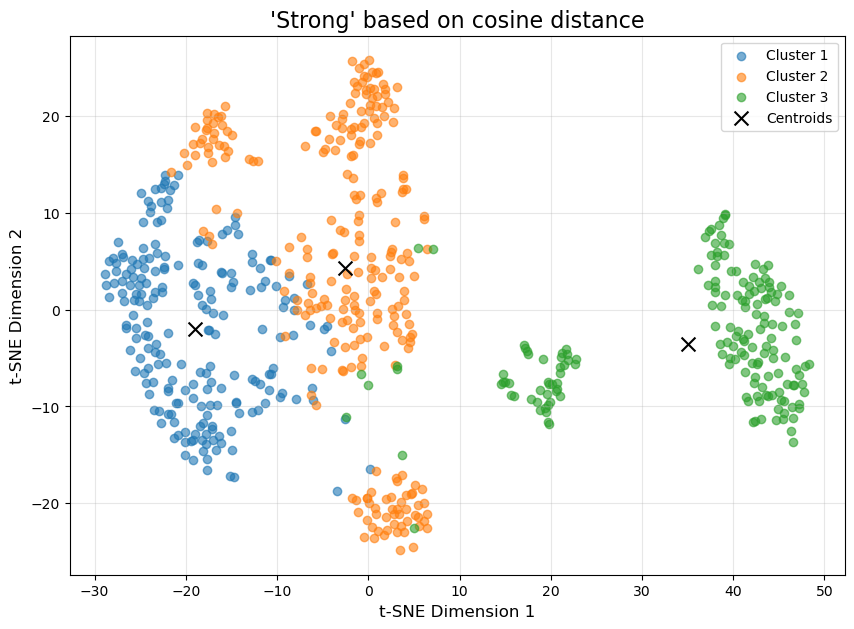

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features (not centroids separately)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(feats_np_norm)  # Project features to 2D

# Map centroids to 2D space using the same transformation
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the t-SNE-transformed features
plt.figure(figsize=(10, 7))
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", alpha=0.6)

# Plot the centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("'Strong' based on cosine distance", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


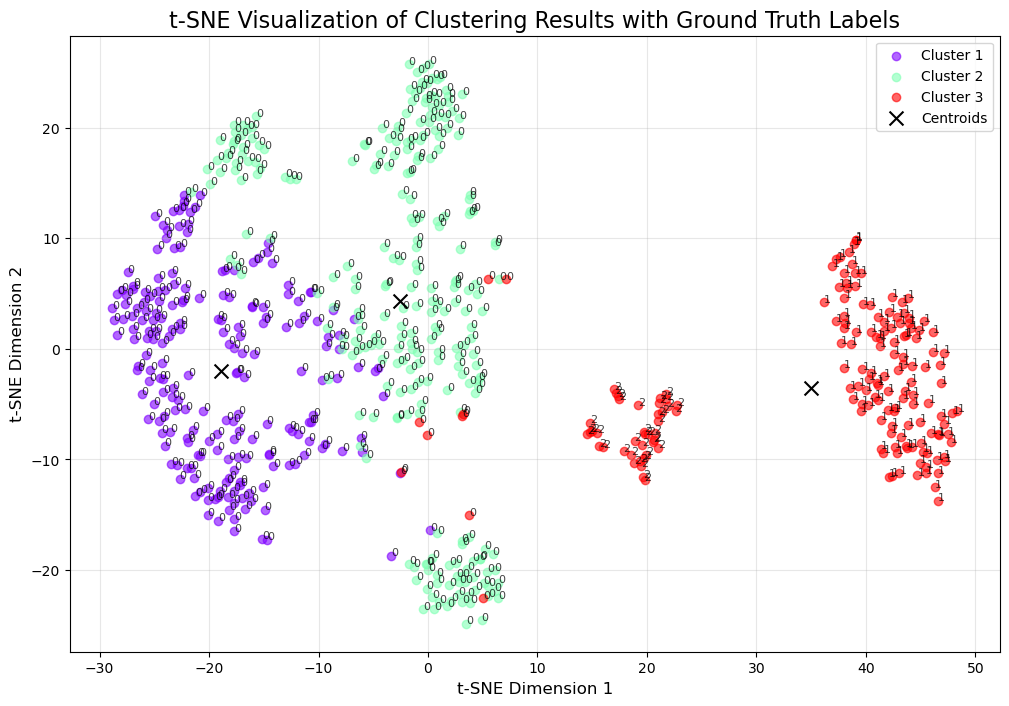

In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features (not centroids separately)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(feats_np_norm)  # Project features to 2D

# Map centroids to 2D space using the same transformation
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the t-SNE-transformed features
plt.figure(figsize=(12, 8))

# Define color map for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster with points and ground truth labels
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    cluster_labels = labels_np[best_idx == cluster_id]  # True labels for the current cluster

    # Scatter plot for cluster points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

    # Annotate each point with its true label
    for i, label in enumerate(cluster_labels):
        plt.annotate(str(label), 
                     (cluster_points[i, 0], cluster_points[i, 1]), 
                     fontsize=8, alpha=0.75)

# Plot centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
            color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("t-SNE Visualization of Clustering Results with Ground Truth Labels", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


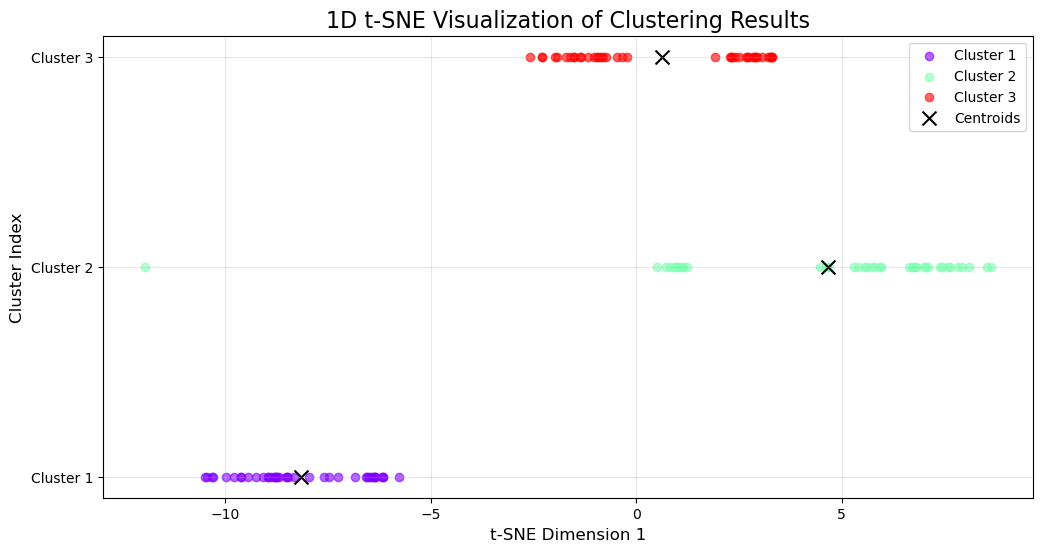

In [77]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE to the normalized features with n_components=1
tsne_1d = TSNE(n_components=1, random_state=42, perplexity=30, n_iter=1000)
features_1d = tsne_1d.fit_transform(feats_np_norm).flatten()  # Project features to 1D and flatten

# Map centroids to 1D space using the mean of cluster points in t-SNE space
centroids_1d = np.array([
    np.mean(features_1d[best_idx == cluster_id]) 
    for cluster_id in range(K)
])

# Create a 1D scatter plot of the t-SNE-transformed features
plt.figure(figsize=(12, 6))

# Define colors for each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster
for cluster_id in range(K):
    cluster_points = features_1d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points, [cluster_id] * len(cluster_points), 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

# Plot the centroids
plt.scatter(centroids_1d, range(K), color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("1D t-SNE Visualization of Clustering Results", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("Cluster Index", fontsize=12)
plt.yticks(range(K), [f"Cluster {i+1}" for i in range(K)])
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


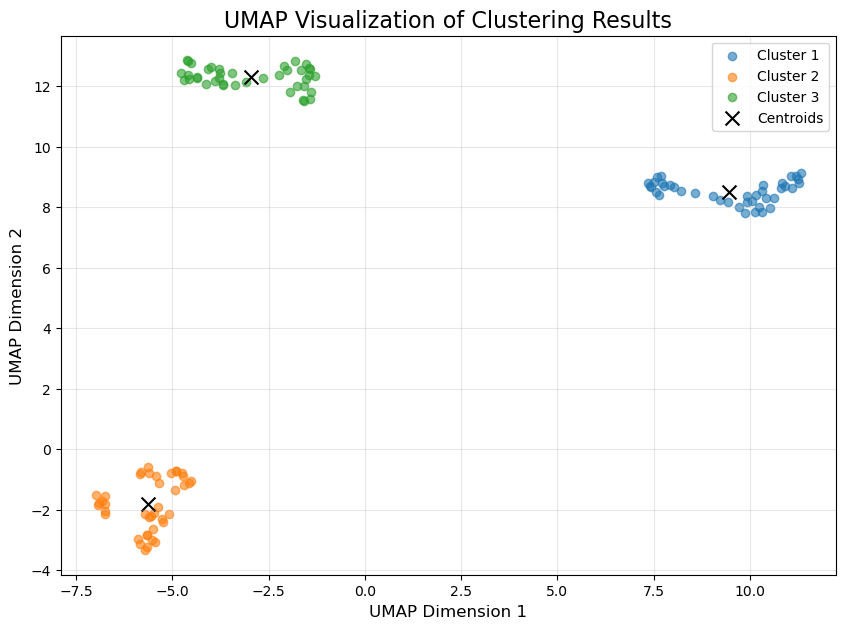

In [78]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Apply UMAP to the normalized features (not centroids separately)
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
features_2d = umap_model.fit_transform(feats_np_norm)  # Project features to 2D

# Map centroids to 2D space using the mean of the cluster points in UMAP space
centroids_2d = np.array([
    np.mean(features_2d[best_idx == cluster_id], axis=0)
    for cluster_id in range(K)
])

# Create a scatter plot of the UMAP-transformed features
plt.figure(figsize=(10, 7))
for cluster_id in range(K):
    cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", alpha=0.6)

# Plot the centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("UMAP Visualization of Clustering Results", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


c:\Users\k54739\.conda\envs\master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


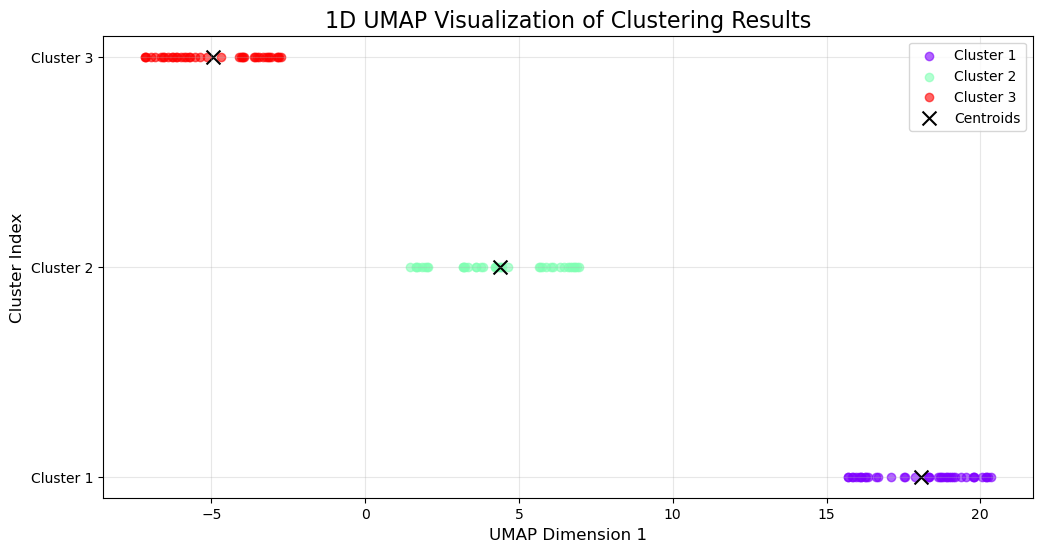

In [79]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Apply UMAP to reduce the normalized features to 1D
umap_1d = umap.UMAP(n_components=1, random_state=42)
features_1d = umap_1d.fit_transform(feats_np_norm).flatten()  # Reduce to 1D and flatten

# Calculate centroids in 1D space using the mean of cluster points
centroids_1d = np.array([
    np.mean(features_1d[best_idx == cluster_id]) 
    for cluster_id in range(K)
])

# Create a 1D scatter plot of the UMAP-transformed features
plt.figure(figsize=(12, 6))

# Define colors for each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, K))

# Plot each cluster
for cluster_id in range(K):
    cluster_points = features_1d[best_idx == cluster_id]  # Points in the current cluster
    plt.scatter(cluster_points, [cluster_id] * len(cluster_points), 
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

# Plot the centroids
plt.scatter(centroids_1d, range(K), color="black", marker="x", s=100, label="Centroids")

# Customize the plot
plt.title("1D UMAP Visualization of Clustering Results", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("Cluster Index", fontsize=12)
plt.yticks(range(K), [f"Cluster {i+1}" for i in range(K)])
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

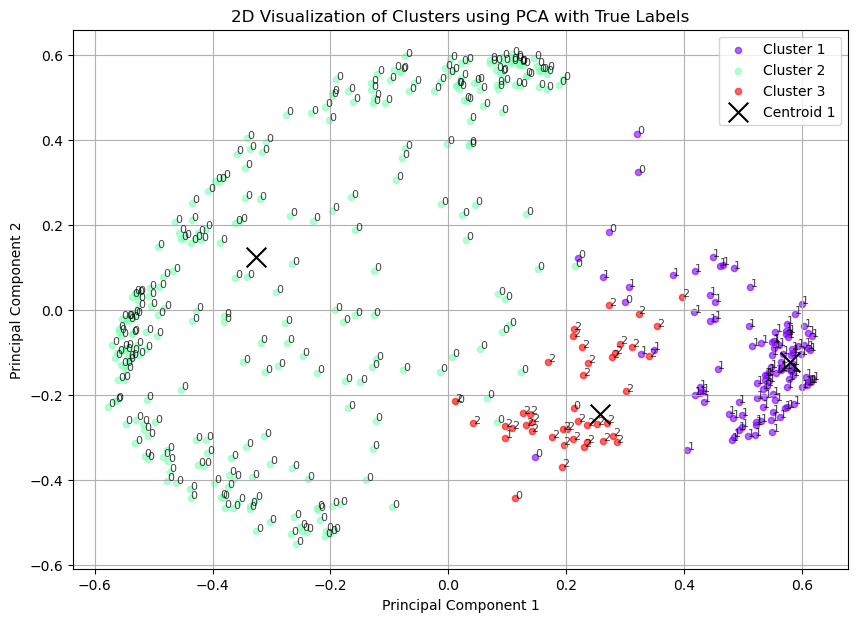

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        # Annotate each point with its true label
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_2D[k, 0], centroids_2D[k, 1], 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)


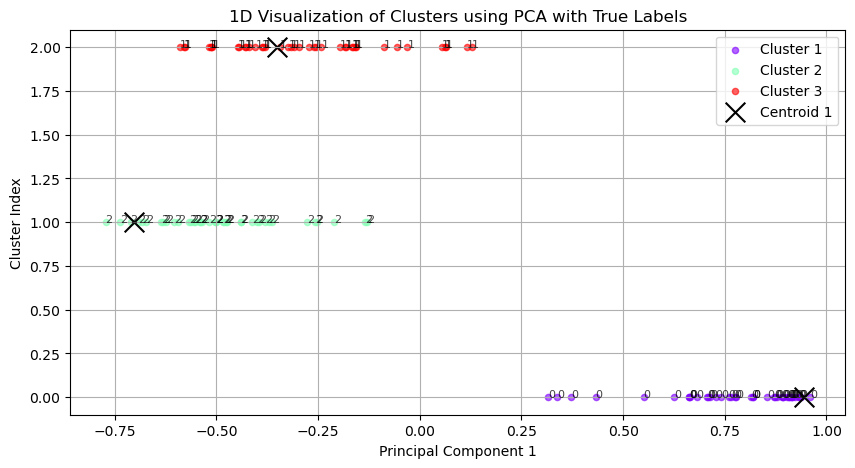


1D PCA values in ascending order: [-0.7727369  -0.7362617  -0.71124464 -0.69298035 -0.68383217 -0.67244536
 -0.63508487 -0.63031197 -0.6233439  -0.6045983  -0.5953351  -0.5894358
 -0.5797443  -0.57706374 -0.5668032  -0.56256354 -0.55428594 -0.55187136
 -0.5413094  -0.5403842  -0.5358867  -0.51794946 -0.51761913 -0.5142152
 -0.5141319  -0.51002264 -0.5030613  -0.50051796 -0.5000802  -0.48364612
 -0.48160037 -0.47675976 -0.4743865  -0.4472654  -0.443396   -0.4406618
 -0.4387655  -0.43068618 -0.4276239  -0.42091697 -0.41170478 -0.40396076
 -0.3997572  -0.3952815  -0.38875586 -0.38432416 -0.3805113  -0.38000032
 -0.371713   -0.36356774 -0.34299594 -0.32282168 -0.31669667 -0.3087983
 -0.2975954  -0.27626297 -0.27341226 -0.26092702 -0.25771132 -0.2561104
 -0.25390548 -0.24195263 -0.21070555 -0.19692242 -0.18315296 -0.18188848
 -0.16599712 -0.16369882 -0.1599284  -0.15782058 -0.13446835 -0.12995629
 -0.08838065 -0.05542072 -0.03047748  0.05425318  0.06198743  0.0637994
  0.11486613  0.128541

In [82]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to reduce the dimensionality of data points and centroids to 1D using PCA
def reduce_to_1D_pca(X, centroids):
    # Initialize PCA with 1 component
    pca = PCA(n_components=1)
    
    # Apply PCA to the data points (X) and centroids
    X_1D = pca.fit_transform(X)  # Reducing original data points
    centroids_1D = pca.transform(centroids)  # Reducing centroids

    return X_1D, centroids_1D

# Function to plot 1D visualization of clustered data points and centroids with true labels
def plot_1D_clusters_with_labels(X_1D, centroids_1D, idx, labels, K):
    plt.figure(figsize=(10, 5))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_1D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points, [k] * len(cluster_points), 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6, s=20)
        
        # Annotate each point with its true label
        for i in range(len(cluster_points)):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i], k), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    for k in range(K):
        plt.scatter(centroids_1D[k], k, 
                    c='k', marker='x', s=200, label=f'Centroid {k+1}' if k == 0 else "")

    plt.title("1D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Cluster Index")
    plt.legend()
    plt.grid()
    plt.show()

# Apply PCA after K-Means clustering for 1D visualization
X_1D_pca, centroids_1D_pca = reduce_to_1D_pca(feats_np_norm, best_centroids)

# Plot the 1D clusters with centroids and true labels
plot_1D_clusters_with_labels(X_1D_pca, centroids_1D_pca, best_idx, labels_np, K)

# Print the 1D values (PCA scores) in ascending order
sorted_X_1D = np.sort(X_1D_pca.flatten())  # Flatten and sort the PCA scores
print("\n1D PCA values in ascending order:", sorted_X_1D)

# Sort the 1D centroid values and map to labels
sorted_centroids_idx = np.argsort(centroids_1D_pca.flatten())
true_labels_mapping = ['control', 'sd', 'ex']
sorted_labels = [true_labels_mapping[i] for i in sorted_centroids_idx]

# Print sorted centroids with their corresponding true labels
print("\nCentroids in ascending order:")
for i, idx in enumerate(sorted_centroids_idx):
    print(f"Centroid {i+1}: {sorted_labels[i]}, Value: {centroids_1D_pca[idx][0]:.4f}")

In [83]:
import numpy as np

def calculate_middle_cluster_accuracy(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    print("Debugging Information:")
    print(f"Shape of X_1D: {X_1D.shape}")
    print(f"Shape of idx (after fix): {idx.shape}")
    print(f"Shape of centroids_1D: {centroids_1D.shape}")
    print(f"Unique cluster indices: {np.unique(idx)}")
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    print(f"Centroid values: {centroid_values}")
    print(f"Sorted centroid indices: {sorted_indices}")
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Now we work with the reindexed clusters
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    print(f"\nCluster sizes after reindexing:")
    print(f"First cluster points: {len(first_cluster_points)}")
    print(f"Middle cluster points: {len(middle_cluster_points)}")
    print(f"Third cluster points: {len(third_cluster_points)}")
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing. Please check cluster assignments.")
    
    # Calculate boundary values
    first_cluster_max = np.max(first_cluster_points)
    third_cluster_min = np.min(third_cluster_points)
    
    # Count errors
    errors_below = np.sum(middle_cluster_points < first_cluster_max)
    errors_above = np.sum(middle_cluster_points > third_cluster_min)
    total_errors = errors_below + errors_above
    total_points = 40+40+40
    # Calculate accuracy
    total_middle_points = len(middle_cluster_points)
    accuracy = (total_points - total_errors) / total_points
    
    # Print boundary information
    print(f"\nBoundary Information:")
    print(f"First cluster range: [{np.min(first_cluster_points):.4f}, {first_cluster_max:.4f}]")
    print(f"Middle cluster range: [{np.min(middle_cluster_points):.4f}, {np.max(middle_cluster_points):.4f}]")
    print(f"Third cluster range: [{third_cluster_min:.4f}, {np.max(third_cluster_points):.4f}]")
    
    return {
        'accuracy': accuracy,
        'total_points': total_middle_points,
        'errors_below': errors_below,
        'errors_above': errors_above,
        'total_errors': total_errors,
        'first_cluster_max': first_cluster_max,
        'third_cluster_min': third_cluster_min
    }

# Try to calculate the accuracy metrics with error handling
try:
    # Use best_idx from our successful K-means clustering
    results = calculate_middle_cluster_accuracy(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nResults:")
    print(f"Total points in middle cluster: {results['total_points']}")
    print(f"Errors below first cluster max: {results['errors_below']}")
    print(f"Errors above third cluster min: {results['errors_above']}")
    print(f"Total errors: {results['total_errors']}")
    print(f"Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check:")
    print("1. The original cluster assignments")
    print("2. The K-means clustering results")
    print("3. The PCA transformation process")

Debugging Information:
Shape of X_1D: (120, 1)
Shape of idx (after fix): (120,)
Shape of centroids_1D: (3, 1)
Unique cluster indices: [0 1 2]
Centroid values: [ 0.9452428  -0.70145109 -0.35174202]
Sorted centroid indices: [1 2 0]

Cluster sizes after reindexing:
First cluster points: 40
Middle cluster points: 40
Third cluster points: 40

Boundary Information:
First cluster range: [-0.7727, -0.1300]
Middle cluster range: [-0.5894, 0.1285]
Third cluster range: [0.3151, 0.9596]

Results:
Total points in middle cluster: 40
Errors below first cluster max: 32
Errors above third cluster min: 0
Total errors: 32
Accuracy: 0.7333 (73.33%)


In [84]:
import numpy as np

def calculate_cluster_accuracy_both_metrics(X_1D, idx, centroids_1D):
    # Convert idx to array if it's not already
    if not isinstance(idx, np.ndarray):
        idx = np.array(idx)
    
    # Ensure idx is the same length as X_1D
    if idx.shape != (len(X_1D),):
        print("Warning: Reshaping idx to match data points")
        idx = np.full(len(X_1D), idx)
    
    print("Debugging Information:")
    print(f"Shape of X_1D: {X_1D.shape}")
    print(f"Shape of idx (after fix): {idx.shape}")
    print(f"Shape of centroids_1D: {centroids_1D.shape}")
    print(f"Unique cluster indices: {np.unique(idx)}")
    
    # Sort centroids and get their indices
    centroid_values = centroids_1D.flatten()
    sorted_indices = np.argsort(centroid_values)
    print(f"Centroid values: {centroid_values}")
    print(f"Sorted centroid indices: {sorted_indices}")
    
    # Map old cluster indices to new ordered indices (0, 1, 2)
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    
    # Reindex the clusters to be 0, 1, 2 in order of centroid values
    new_idx = np.zeros_like(idx)
    for old_idx, new_idx_val in index_mapping.items():
        new_idx[idx == old_idx] = new_idx_val
    
    # Now we work with the reindexed clusters
    # Get points belonging to each cluster
    first_cluster_points = X_1D[new_idx == 0]
    middle_cluster_points = X_1D[new_idx == 1]
    third_cluster_points = X_1D[new_idx == 2]
    
    print(f"\nCluster sizes after reindexing:")
    print(f"First cluster points: {len(first_cluster_points)}")
    print(f"Middle cluster points: {len(middle_cluster_points)}")
    print(f"Third cluster points: {len(third_cluster_points)}")
    
    # Check if any clusters are empty
    if len(first_cluster_points) == 0 or len(middle_cluster_points) == 0 or len(third_cluster_points) == 0:
        raise ValueError("One or more clusters are empty after reindexing. Please check cluster assignments.")
    
    # Calculate boundary values for original metric
    first_cluster_max = np.max(first_cluster_points)
    third_cluster_min = np.min(third_cluster_points)
    
    # Calculate boundary values for new metric
    middle_cluster_min = np.min(middle_cluster_points)
    middle_cluster_max = np.max(middle_cluster_points)
    
    # Count errors for original metric (middle cluster errors)
    middle_errors_below = np.sum(middle_cluster_points < first_cluster_max)
    middle_errors_above = np.sum(middle_cluster_points > third_cluster_min)
    total_middle_errors = middle_errors_below + middle_errors_above
    
    # Count errors for new metric (outer clusters errors)
    first_cluster_errors = np.sum(first_cluster_points > middle_cluster_min)
    third_cluster_errors = np.sum(third_cluster_points < middle_cluster_max)
    total_outer_errors = first_cluster_errors + third_cluster_errors
    
    total_points = len(first_cluster_points) + len(middle_cluster_points) + len(third_cluster_points)
    
    # Calculate accuracies
    middle_accuracy = (total_points - total_middle_errors) / total_points
    outer_accuracy = (total_points - total_outer_errors) / total_points
    
    # Print boundary information
    print(f"\nBoundary Information:")
    print(f"First cluster range: [{np.min(first_cluster_points):.4f}, {first_cluster_max:.4f}]")
    print(f"Middle cluster range: [{middle_cluster_min:.4f}, {middle_cluster_max:.4f}]")
    print(f"Third cluster range: [{third_cluster_min:.4f}, {np.max(third_cluster_points):.4f}]")
    
    # Print detailed error counts for debugging
    print("\nDetailed Error Analysis:")
    print("Original Metric (Middle cluster errors):")
    print(f"Middle points below first max: {middle_errors_below}")
    print(f"Middle points above third min: {middle_errors_above}")
    print("\nNew Metric (Outer clusters errors):")
    print(f"First cluster points above middle min: {first_cluster_errors}")
    print(f"Third cluster points below middle max: {third_cluster_errors}")
    
    return {
        # Original metric results
        'middle_accuracy': middle_accuracy,
        'middle_errors_below': middle_errors_below,
        'middle_errors_above': middle_errors_above,
        'total_middle_errors': total_middle_errors,
        
        # New metric results
        'outer_accuracy': outer_accuracy,
        'first_cluster_errors': first_cluster_errors,
        'third_cluster_errors': third_cluster_errors,
        'total_outer_errors': total_outer_errors,
        
        # Boundary values
        'first_cluster_max': first_cluster_max,
        'middle_cluster_min': middle_cluster_min,
        'middle_cluster_max': middle_cluster_max,
        'third_cluster_min': third_cluster_min,
        
        'total_points': total_points
    }

# Try to calculate both accuracy metrics with error handling
try:
    # Use best_idx from the K-means clustering
    results = calculate_cluster_accuracy_both_metrics(X_1D_pca, best_idx, centroids_1D_pca)
    
    print(f"\nFinal Results:")
    print("\nOriginal Metric (Middle cluster errors):")
    print(f"Total errors: {results['total_middle_errors']}")
    print(f"Accuracy: {results['middle_accuracy']:.4f} ({results['middle_accuracy']*100:.2f}%)")
    
    print("\nNew Metric (Outer clusters errors):")
    print(f"Total errors: {results['total_outer_errors']}")
    print(f"Accuracy: {results['outer_accuracy']:.4f} ({results['outer_accuracy']*100:.2f}%)")
    
except ValueError as e:
    print(f"Error: {e}")
    print("Additional debugging needed. Please check:")
    print("1. The original cluster assignments")
    print("2. The K-means clustering results")
    print("3. The PCA transformation process")

Debugging Information:
Shape of X_1D: (120, 1)
Shape of idx (after fix): (120,)
Shape of centroids_1D: (3, 1)
Unique cluster indices: [0 1 2]
Centroid values: [ 0.9452428  -0.70145109 -0.35174202]
Sorted centroid indices: [1 2 0]

Cluster sizes after reindexing:
First cluster points: 40
Middle cluster points: 40
Third cluster points: 40

Boundary Information:
First cluster range: [-0.7727, -0.1300]
Middle cluster range: [-0.5894, 0.1285]
Third cluster range: [0.3151, 0.9596]

Detailed Error Analysis:
Original Metric (Middle cluster errors):
Middle points below first max: 32
Middle points above third min: 0

New Metric (Outer clusters errors):
First cluster points above middle min: 29
Third cluster points below middle max: 0

Final Results:

Original Metric (Middle cluster errors):
Total errors: 32
Accuracy: 0.7333 (73.33%)

New Metric (Outer clusters errors):
Total errors: 29
Accuracy: 0.7583 (75.83%)


# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)
